In [5]:
import pandas as pd
import ast
from tqdm import tqdm
import re

import nltk
from nltk.collocations import *

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from tqdm import tqdm

import string
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
from scipy.stats import mannwhitneyu

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jaspreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def count_finer_distribution(df, full_df):
    finer_counts = {}
    finer_counts_proportion = {}
    
    finer_counts_full_df = {}

    
    finer_all = list(df['frames']) 
    for i in finer_all:
#         clean = ast.literal_eval(i)
        clean = i
        
        for lab in clean:
            if lab not in finer_counts:
                finer_counts[lab] = 0
            finer_counts[lab]+=1
            
    finer_all_full = list(full_df['frames'])
    for j in finer_all_full:
#         clean = ast.literal_eval(i)
        clean_full = j

        for lab_full in clean_full:
            if lab_full not in finer_counts_full_df:
                finer_counts_full_df[lab_full] = 0
            finer_counts_full_df[lab_full]+=1

    for finer_label in finer_counts:
        finer_counts_proportion[finer_label] = finer_counts[finer_label] / df.shape[0]
    return finer_counts_proportion
    
    
    
def count_finer(df):
    finer_counts = {}
    finer_counts_proportion = {}
    finer_counts_full_df = {}
    
    finer_all = list(df['frames_x'])
    for i in finer_all:
        clean = i
        
        for lab in clean:
            if lab not in finer_counts:
                finer_counts[lab] = 0
            finer_counts[lab]+=1
            
            
    for finer_label in finer_counts:
        finer_counts_proportion[finer_label] = finer_counts[finer_label]
    
    
    return finer_counts_proportion
    

    

def count_co(one, two, df):
    # out of tweets that contain homeless vet, calculate proportion that also contain immigrant 
    vet_immi = 0
    both = 0
    for idx, row in df.iterrows():
        if row[one] == True or row[two] == True:
            both+=1
            
        if row[one] == True and row[two] == True:
            vet_immi+=1
    print(vet_immi/both)
    
    

def run_man_whitney(df, df_orig):
    num_trials = 10000
    cats = ['deserving_undeserving_of_resources', 'government_critique', 'money_aid_resource_allocation',\
            'solutions_interventions', 'societal_critique', 'harmful_generalization', 'personal_interaction_observation_of_homelessness',\
           'not_in_my_backyard','media_portrayal']

    for frame in cats:
        print("Frame: ", frame)

        iden_pop = []
        non_iden_pop = []

        for trial in tqdm(range(num_trials)):
            if df.shape[0] < 50:
                n = df.shape[0]
            else:
                n=50
            sample_id = count_finer(df.sample(n=n, replace=False))
            sample_non_id = count_finer(df_orig.sample(n=50, replace=False))

            if frame in sample_id:
                iden_pop.append(sample_id[frame])
            else:
                iden_pop.append(0)

            if frame in sample_non_id:
                non_iden_pop.append(sample_non_id[frame])
            else:
                non_iden_pop.append(0)

        print(mannwhitneyu(iden_pop, non_iden_pop, alternative='greater'))
    
    
    
# load set of annotations

def load_anns_region(ner_path, analysis_path):
    anns = ner_path
    print("read anns")
    print("starting to read flan anns")
    flan_anns = analysis_path
    print("read both anns and flan anns")
    flags = []

    for idx, row in flan_anns.iterrows():
        if idx % 10000 == 0:
            print(idx)
        finer = row['frames']
        if type(finer) == str:
            if finer =='[]':
                flags.append(False)
        else:
            if len(finer) == 0 or '0' in finer:
                flags.append(False)
            else:
                flags.append(True)
    flan_anns = flan_anns[flags]
    ret_anns = anns
    ret_anns['frames'] = flan_anns.iloc[ret_anns.index]['frames']


    print(ret_anns.shape)
    ret_anns = ret_anns.reset_index()
#     ret_anns['idx'] = ret_anns.index
    return ret_anns, flan_anns
    

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import OrderedDict


def plot_time_series(df_result, title): 

    finer_distribution_month = {}
    date_value_counts = dict(df_result['date'].value_counts())

    for date in date_value_counts:
        # get subset of posts in this date 
        result_sub = df_result.loc[df_result['date'] == date]
        # get finer distribution of frames in that month 

        dist = count_finer(result_sub)
        finer_distribution_month[date] = dist

    new_d = OrderedDict(sorted(finer_distribution_month.items()))
    ordered_time = dict(new_d)

    # Your dictionary
    data = ordered_time

    # Convert dictionary to DataFrame
    df = pd.DataFrame(data).T

    # Reset index to have dates as a column
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'date'}, inplace=True)

    # Melt DataFrame to have a tidy format for seaborn
    df = pd.melt(df, id_vars=['date'], var_name='category', value_name='value')

    custom_palette = {
        'deserving_undeserving_of_resources': '#fd7f6f',
        'government_critique': '#7eb0d5',
        'money_aid_resource_allocation': '#b2e061',
        'solutions_interventions': '#bd7ebe',
        'societal_critique': '#ffb55a',
        'harmful_generalization': '#ffee65',
        'personal_interaction_observation_of_homelessness': '#beb9db',
        'not_in_my_backyard': '#fdcce5',
        'media_portrayal': '#8bd3c7'
    }


    # Plot using seaborn with custom palette
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='date', y='value', hue='category', marker='o', palette=custom_palette, linewidth=3)
    sns.despine()
    plt.xlabel("")
    plt.ylabel('Frequency of posts labeled with frames', fontsize=18)
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Customize legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = ['deserving_undeserving_of_resources', 'government_critique', 'money_aid_resource_allocation',
             'solutions_interventions', 'societal_critique', 'harmful_generalization',
             'personal_interaction_observation_of_homelessness', 'not_in_my_backyard', 'media_portrayal']
    mapping = {'deserving_undeserving_of_resources': '(Un)Deserv.', 
               'government_critique': 'GovCrit.', 
               'money_aid_resource_allocation': 'MoneyAid.',
               'solutions_interventions': 'SolnInt.', 
               'societal_critique': 'SocCrit.', 
               'harmful_generalization': 'HarmGen.', 
               'personal_interaction_observation_of_homelessness': 'Interact.',
               'not_in_my_backyard': 'NIMBY',
               'media_portrayal': 'MediaPort.'}
    
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    
    order_idx = [labels.index(category) for category in order]
    leg= plt.legend([handles[i] for i in order_idx], [mapping[labels[i]] for i in order_idx], loc='upper left', fontsize=15, bbox_to_anchor=(0.02, -0.35), ncol=5) 

    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    
    plt.savefig("../../plots/time_" +title+ "_pastel.pdf",bbox_inches='tight')

    plt.show()




    


In [ ]:
analysis_path = load_dataset("dill-lab/oath-frames-model-predicted-annotations")['train'].to_pandas()
ner_path = load_dataset("dill-lab/oath-frames-analysis-ner")['train'].to_pandas() # from huggingface: ner.jsonl


In [11]:
anns_region, df_analysis = load_anns_region(ner_path, analysis_path)


read anns
starting to read flan anns
read both anns and flan anns
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000


# New york

In [16]:
result = pd.merge(df_analysis, anns_region, left_on="tweet",right_on="tweet_processed", how='left')
print(result.shape)
print(df_analysis.shape)

(2425728, 60)
(2425669, 3)


In [17]:
# result['date'] = result['created_at_x'].dt.strftime('%Y-%m')
# result['time'] = result['created_at_x'].dt.strftime('%H:%M:%S')

result['date'] = result['created_at_x'].dt.strftime('%Y-%m-%d')
result['time'] = result['created_at_x'].dt.strftime('%H:%M:%S')

In [18]:
df_result = result.loc[result['New York'] == True]

finer_distribution_month = {}
date_value_counts = dict(df_result['date'].value_counts())

for date in date_value_counts:
    # get subset of posts in this date 
    result_sub = df_result.loc[df_result['date'] == date]
    # get finer distribution of frames in that month 

    dist = count_finer(result_sub)
    finer_distribution_month[date] = dist


from collections import OrderedDict

new_d = OrderedDict(sorted(finer_distribution_month.items()))
ordered_time = dict(new_d)

# Your dictionary
data = ordered_time

# Convert dictionary to DataFrame
df = pd.DataFrame(data).T

# Reset index to have dates as a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

# Melt DataFrame to have a tidy format for seaborn
df = pd.melt(df, id_vars=['date'], var_name='category', value_name='value')



In [19]:
custom_palette = {
    'deserving_undeserving_of_resources': '#e60049',
    'government_critique': '#0bb4ff',
    'money_aid_resource_allocation': '#50e991',
    'solutions_interventions': '#e6d800',
    'societal_critique': '#9b19f5',
    'harmful_generalization': '#ffa300',
    'personal_interaction_observation_of_homelessness': '#dc0ab4',
    'not_in_my_backyard': '#b3d4ff',
    'media_portrayal': '#00bfa0'
}

In [20]:
df = df.fillna(0.0)
df = df[df.date != '2023-02-16']


order = ['deserving_undeserving_of_resources', 'government_critique', 'money_aid_resource_allocation',
         'solutions_interventions', 'societal_critique', 'harmful_generalization',
         'personal_interaction_observation_of_homelessness', 'not_in_my_backyard', 'media_portrayal']


new = []
for i in order:
    new.append(['2023-01-25', i, 0.0])
    new.append(['2023-01-26', i, 0.0])
        
    # New data as pandas.DataFrame
new = pd.DataFrame(columns=df.columns, data=new)
# Overwrite original dataframe
df = pd.concat([df, new], axis=0)

df = df.sort_values(by='date')

In [21]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)

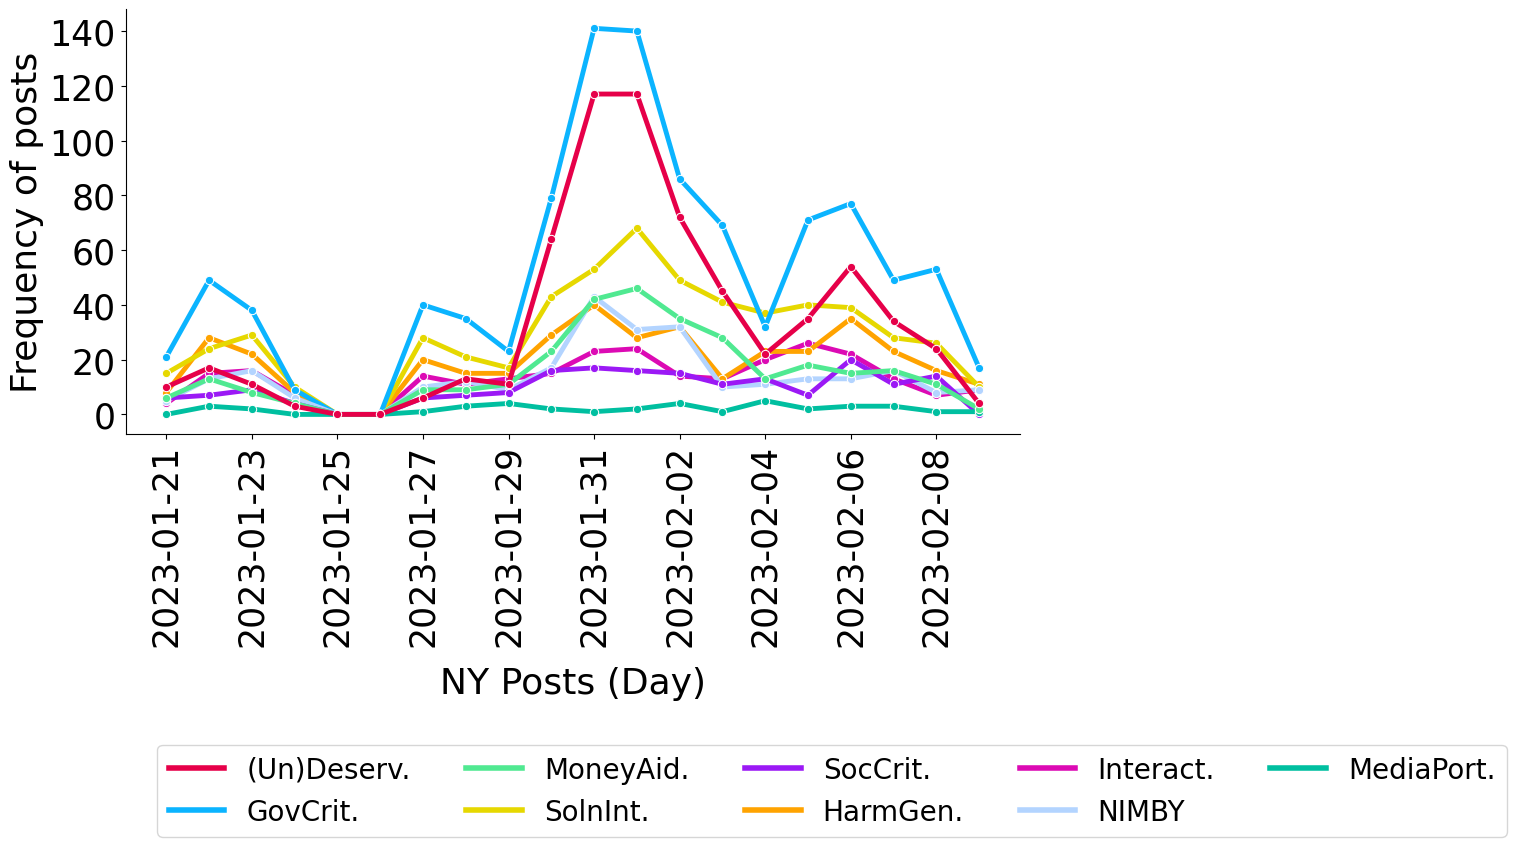

In [22]:
# Plot using seaborn with custom palette
title = 'newyork_time'

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='date', y='value', hue='category', marker='o', palette=custom_palette, linewidth=3.5)

sns.despine() 

plt.xlabel("")
plt.ylabel('Frequency of posts', fontsize=26)
plt.xlabel('NY Posts (Day)', fontsize=26, labelpad=15)

plt.xticks(rotation=90)
plt.tight_layout()

# Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['deserving_undeserving_of_resources', 'government_critique', 'money_aid_resource_allocation',
         'solutions_interventions', 'societal_critique', 'harmful_generalization',
         'personal_interaction_observation_of_homelessness', 'not_in_my_backyard', 'media_portrayal']
mapping = {'deserving_undeserving_of_resources': '(Un)Deserv.', 
           'government_critique': 'GovCrit.', 
           'money_aid_resource_allocation': 'MoneyAid.',
           'solutions_interventions': 'SolnInt.', 
           'societal_critique': 'SocCrit.', 
           'harmful_generalization': 'HarmGen.', 
           'personal_interaction_observation_of_homelessness': 'Interact.',
           'not_in_my_backyard': 'NIMBY',
           'media_portrayal': 'MediaPort.'}

# plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


# Get current x-tick labels
current_xticks = plt.gca().get_xticks()
current_xtick_labels = plt.gca().get_xticklabels()

# Set x-ticks to every other tick
plt.xticks(current_xticks[::2], current_xtick_labels[::2], fontsize=25)


order_idx = [labels.index(category) for category in order]
#     plt.legend([handles[i] for i in order_idx], [mapping[labels[i]] for i in order_idx], loc='upper left', fontsize=15, bbox_to_anchor=(1.0, 1)) 

#     plt.legend([handles[i] for i in order_idx], [mapping[labels[i]] for i in order_idx], loc='upper left', fontsize=15, bbox_to_anchor=(0.02, -0.3), ncol=5) 
leg = plt.legend([handles[i] for i in order_idx], [mapping[labels[i]] for i in order_idx], loc='upper left', fontsize=20, bbox_to_anchor=(0.02, -0.7), ncol=5) 

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

    
# plt.savefig("../../plots/time_" +title+ "sub_vibrant.pdf",bbox_inches='tight')

plt.show()

# all states

In [23]:
result = pd.merge(df_analysis, anns_region, left_on="tweet",right_on="tweet_processed", how='left')
print(result.shape)
print(df_analysis.shape)
result['date'] = result['created_at_x'].dt.strftime('%Y-%m')
result['time'] = result['created_at_x'].dt.strftime('%H:%M:%S')


df_result = result

finer_distribution_month = {}
date_value_counts = dict(df_result['date'].value_counts())

for date in date_value_counts:
    # get subset of posts in this date 
    result_sub = df_result.loc[df_result['date'] == date]
    # get finer distribution of frames in that month 

    dist = count_finer(result_sub)
    finer_distribution_month[date] = dist

new_d = OrderedDict(sorted(finer_distribution_month.items()))
ordered_time = dict(new_d)

# Your dictionary
data = ordered_time

# Convert dictionary to DataFrame
df = pd.DataFrame(data).T

# Reset index to have dates as a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

# Melt DataFrame to have a tidy format for seaborn
df = pd.melt(df, id_vars=['date'], var_name='category', value_name='value')




(2425728, 60)
(2425669, 3)


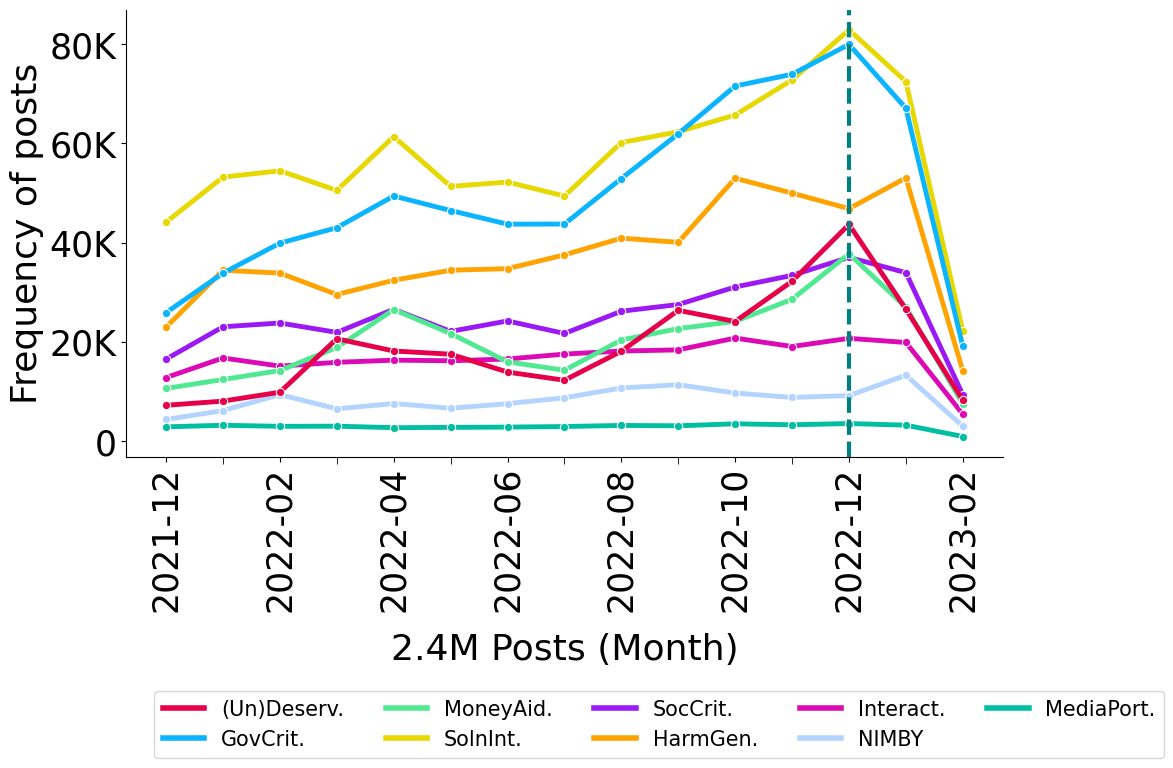

In [24]:
from matplotlib.ticker import AutoMinorLocator

title = 'Frequency of Frames Across Time in 2.4M Posts'


plt.figure(figsize=(10, 6))


sns.lineplot(data=df, x='date', y='value', hue='category', marker='o', palette=custom_palette, linewidth=3.5)

sns.despine() 

x_value = '2022-12'  # Example: annotate at '2022-06'
plt.axvline(x_value, color='teal', linestyle='--', linewidth=3)

plt.xlabel("")
plt.ylabel('Frequency of posts', fontsize=26)
plt.xlabel('2.4M Posts (Month)', fontsize=26, labelpad=15)

plt.xticks(rotation=90)
plt.tight_layout()

# Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['deserving_undeserving_of_resources', 'government_critique', 'money_aid_resource_allocation',
         'solutions_interventions', 'societal_critique', 'harmful_generalization',
         'personal_interaction_observation_of_homelessness', 'not_in_my_backyard', 'media_portrayal']
mapping = {'deserving_undeserving_of_resources': '(Un)Deserv.', 
           'government_critique': 'GovCrit.', 
           'money_aid_resource_allocation': 'MoneyAid.',
           'solutions_interventions': 'SolnInt.', 
           'societal_critique': 'SocCrit.', 
           'harmful_generalization': 'HarmGen.', 
           'personal_interaction_observation_of_homelessness': 'Interact.',
           'not_in_my_backyard': 'NIMBY',
           'media_portrayal': 'MediaPort.'}

# plt.xticks(fontsize=17)
plt.yticks(fontsize=25)
# Get current x-tick labels

current_xticks = plt.gca().get_xticks()
current_xtick_labels = plt.gca().get_xticklabels()

# Set x-ticks to every other tick
plt.xticks(current_xticks[::2], current_xtick_labels[::2], fontsize=25)


custom_y_ticks = [0, 20000, 40000, 60000, 80000]
custom_y_labels = ['0', '20K', '40K', '60K', '80K']

plt.yticks(custom_y_ticks, custom_y_labels, fontsize=25)



# Add minor ticks
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().tick_params(axis='x', which='minor', length=5)



order_idx = [labels.index(category) for category in order] 
leg = plt.legend([handles[i] for i in order_idx], [mapping[labels[i]] for i in order_idx], loc='upper left', fontsize=15, bbox_to_anchor=(0.02, -0.5), ncol=5) 

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

    
# plt.savefig("../../plots/time_" +title+ "_vibrant.pdf",bbox_inches='tight')

plt.show()
